<a href="https://colab.research.google.com/github/LohithVarun/CSA4736-DeepLearningPrograms/blob/main/Program-16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image: ryujin icon.jpeg
SSIM Score: 0.0497
Edge Accuracy: 0.8994


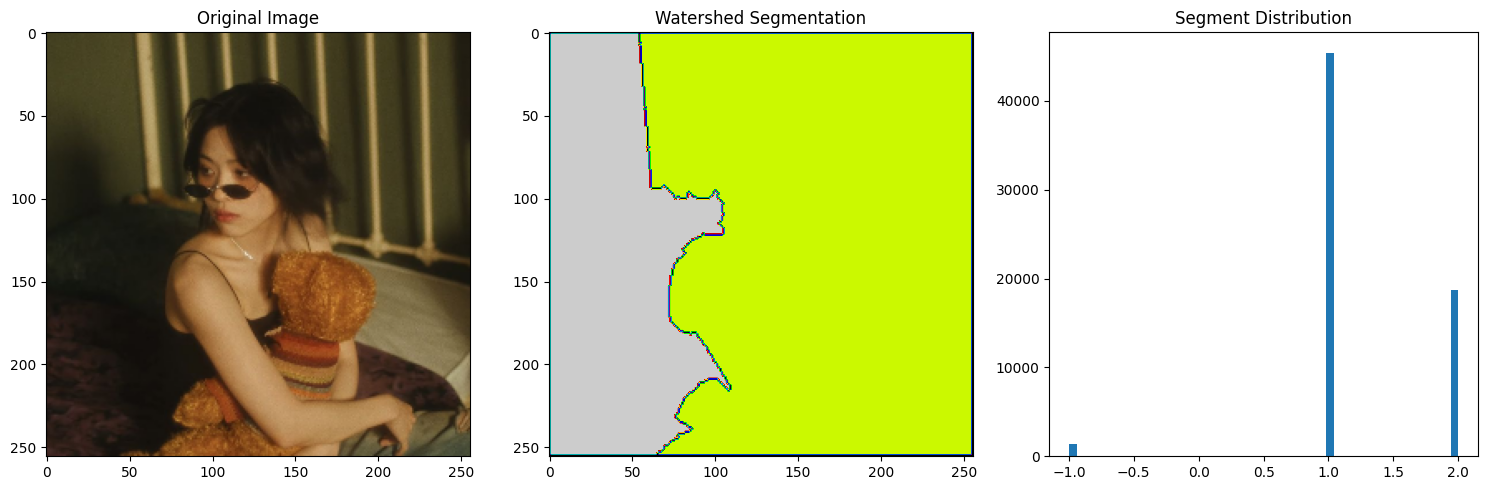

In [20]:
#R.Lohith Varun 192224215
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from skimage.metrics import structural_similarity as ssim
import os

def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)
    return markers

def evaluate_segmentation(original, segmented, ground_truth=None):
    ssim_score = ssim(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY),
                      segmented.astype(np.uint8))

    edge_original = feature.canny(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY))
    edge_segmented = feature.canny(segmented.astype(np.uint8))

    edge_accuracy = np.mean(edge_original == edge_segmented)

    return {
        'ssim_score': ssim_score,
        'edge_accuracy': edge_accuracy
    }

image_path = "ryujin icon.jpeg"

image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image: {image_path}")
else:
    image = cv2.resize(image, (256, 256))
    segmented = watershed_segmentation(image)
    metrics = evaluate_segmentation(image, segmented)

    print(f"Image: {image_path}")
    print(f"SSIM Score: {metrics['ssim_score']:.4f}")
    print(f"Edge Accuracy: {metrics['edge_accuracy']:.4f}")

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.subplot(132)
    plt.imshow(segmented, cmap='nipy_spectral')
    plt.title('Watershed Segmentation')
    plt.subplot(133)
    plt.hist(segmented.ravel(), bins=50)
    plt.title('Segment Distribution')
    plt.tight_layout()
    plt.show()